In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#get the last date 
last_date = engine.execute('SELECT max(date) FROM measurement').fetchone()
print(last_date[0])

2017-08-23


In [9]:
# Calculate the date 1 year ago from the last data point in the database
last_12mnth = (dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
print (last_12mnth)

2016-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12mnth ).\
order_by(Measurement.date).all()
#print(precipitation_data)

In [11]:
# Save the query results as a Pandas DataFrame 
prec_df = pd.DataFrame(precipitation_data)
precipitation_df = prec_df.rename(columns={"prcp":"Precipitation"})
precipitation_df.head()
#set the index to the date column
precipitation_df.set_index('date').head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


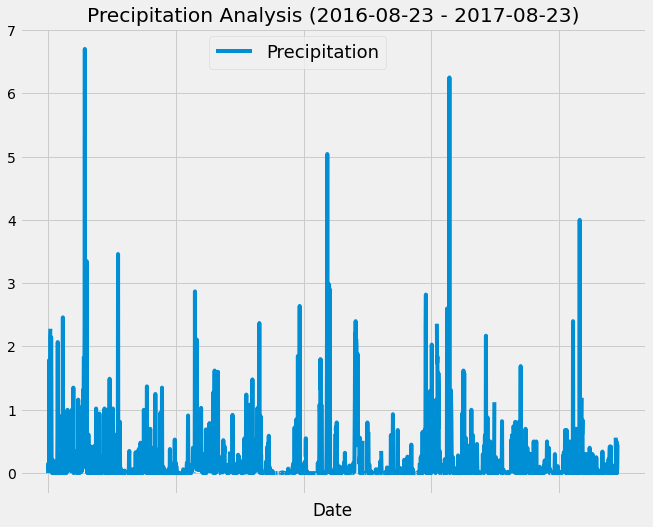

In [12]:
#Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(figsize=(10,8))
plt.legend(bbox_to_anchor=(.6,1.001), fontsize="18")
ax.set_title(f"Precipitation Analysis ({(last_12mnth)} - {last_date[0]})")
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlabel('Date')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.id).count()
print(total_stations)

9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(5).all()
for station in active_stations:
    #print(row)
    # List the stations and the counts in descending order.
    print(f"The most active station is {station[0]} and the total count is {station[1]}. ")

The most active station is USC00519281 and the total count is 2772. 
The most active station is USC00519397 and the total count is 2724. 
The most active station is USC00513117 and the total count is 2709. 
The most active station is USC00519523 and the total count is 2669. 
The most active station is USC00516128 and the total count is 2612. 


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(1).all()
print(most_active_station[0][0])

USC00519281


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observ = session.query(Measurement.tobs).\
              filter(Measurement.station==most_active_station[0][0]).\
                                filter(Measurement.date >= last_12mnth).\
                                order_by(Measurement.date.desc()).all()
temp_observ_df = pd.DataFrame(temp_observ)
temp_observ_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


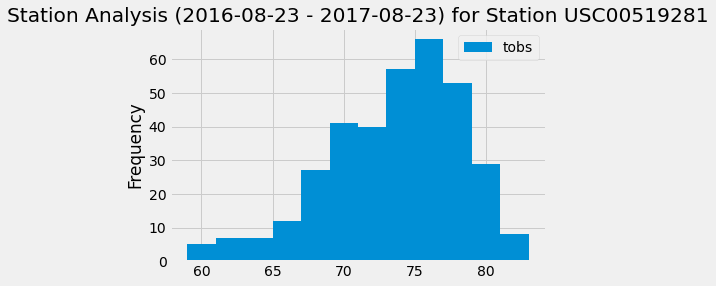

In [19]:
# plt.figure(figsize=(8,4))
plt.hist(temp_observ_df['tobs'], bins=12)
plt.ylabel("Frequency")
plt.title(f"Station Analysis ({(last_12mnth)} - {last_date[0]}) for Station { most_active_station[0][0]}")
plt.legend(["tobs"])
plt.show()

In [20]:
session.close()